# December, 18th 2020

**Motivation**: Find out whether individual neuron traces from different trials are linearly separable.<br>
**Result**: No, there is a large variability between cells even within the same trial.  The responses are mixed.

In [1]:
# HIDE CODE

import os
import sys
import h5py
import pickle
import numpy as np
import pandas as pd
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

github_path = pjoin(os.environ['HOME'], 'Dropbox/git/A1ToneDiscrimination/')
sys.path.insert(0, github_path)
from utils.process import *
from utils.generic_utils import *
from utils.plot_functions import *

## Visualizing trial averages

In this section we plot average responses for a given trial type using all cells from all experiments. Passive trials also included. Different behavior labels are defined as follows:

- target: $7, 10$ kHz
    - For target frequencies, animals should start licking after $1s$ of stimulus presentation ($t = 45$), because there will be a reward present.
    - **hit**: if they lick
    - **miss**: if they don't lick


- nontarget: $14, 20$ kHz
    - For nontarget frequencies, animals should not lick at all because they are trained to detect and ignore these higher frequency stimuli. No reward will be presented during nontarget trials.
    - **correcreject**: if they don't lick
    - **falsealarm**: if they start licking (after few licks they will see that there are no reward and just stop).

Interestingly, at $f = 14$ kHz avg traces for passive and falsealarm trials overlap almost perfectly.  Another interesting point is that during target frequencies, passive trials have larger amplitude compared to behavior trials.  Is this because these are not passive trials, and animals are actively listening with lots of focus, but they don't lick because they know there are no rewards?

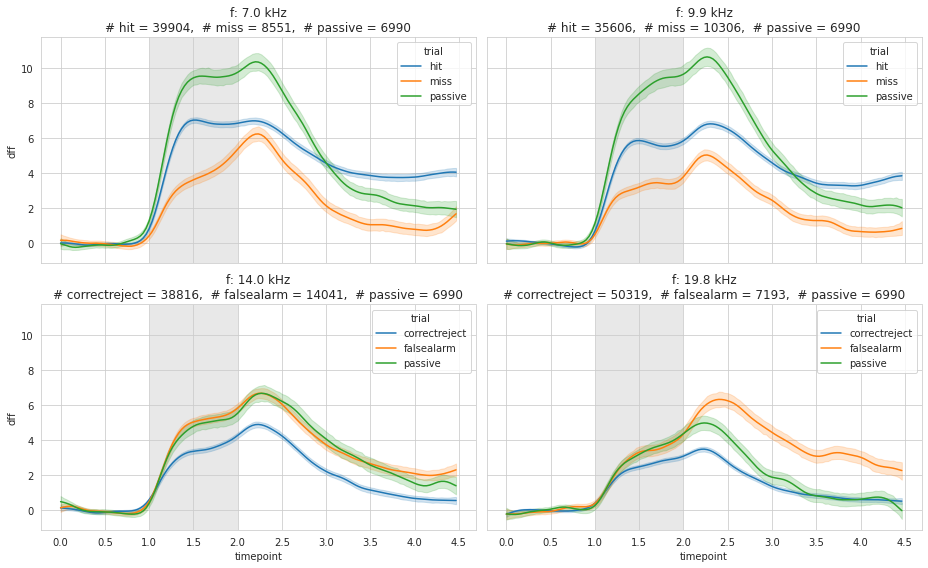

In [2]:
# HIDE CODE

dirs_dict = get_dirs()
df_all = pd.read_pickle(dirs_dict['df_load_file'])

behavior_freqs = sorted(df_all.loc[df_all.trial != 'passive'].stimfreq.unique())
nt = len(df_all.timepoint.unique())
xticks = range(0, nt + 1, 15)

sns.set_style('whitegrid')
fig, ax_arr = plt.subplots(2, 2, figsize=(13, 8), sharex='all', sharey='all')
for idx, freq in enumerate(behavior_freqs):
    i, j = idx // 2, idx % 2
    
    if freq == 7000:
        freq_list = [freq, 7071]
        trials_list = ['hit', 'miss']
    elif freq == 9899:
        freq_list = [freq, 10000]
        trials_list = ['hit', 'miss']
    elif freq == 14000:
        freq_list = [freq, 14142]
        trials_list = ['correctreject', 'falsealarm']
    elif freq == 19799:
        freq_list = [freq, 20000]
        trials_list = ['correctreject', 'falsealarm']
    trials_list.extend(['passive'])
    
    selected_df = df_all.loc[(df_all.stimfreq.isin(freq_list)) & (df_all.trial.isin(trials_list))]
    sns.lineplot(data=selected_df, x='timepoint', y='dff',
                 hue='trial', hue_order=trials_list, ax=ax_arr[i, j])
    ax_arr[i, j].axvspan(30, 60, facecolor='lightgrey', alpha=0.5, zorder=0)
    ax_arr[i, j].set_xticks(xticks)
    ax_arr[i, j].set_xticklabels([t / 30 for t in xticks])
    
    # get title
    trial_counts = Counter(selected_df[selected_df.timepoint == 0].trial)
    msg = "f: {:.1f} kHz\n"
    values = [freq / 1000]
    for label_idx, item in enumerate(trials_list):
        if label_idx == 0:
            msg += "# {:s} = {:d}"
        else:
            msg += ",  # {:s} = {:d}"
        values.extend([item, trial_counts[item]])
    ax_arr[i, j].set_title(msg.format(*values))

fig.tight_layout()
plt.show()

### 95% confidence interval vs. standard deviation

All figures so far are showing mean and the shaded area is 95% CI.  I looked at the source code of the plotting package I'm using to make sure this is the case.  They bootstrap the data *then* computes the confidence interval on it.  This leads to a slightly better result, but at the end of the day it is showing 95% confidecne interval.

Now I will remake above plots, but this time contrasting 95% CI with just standard deviation.

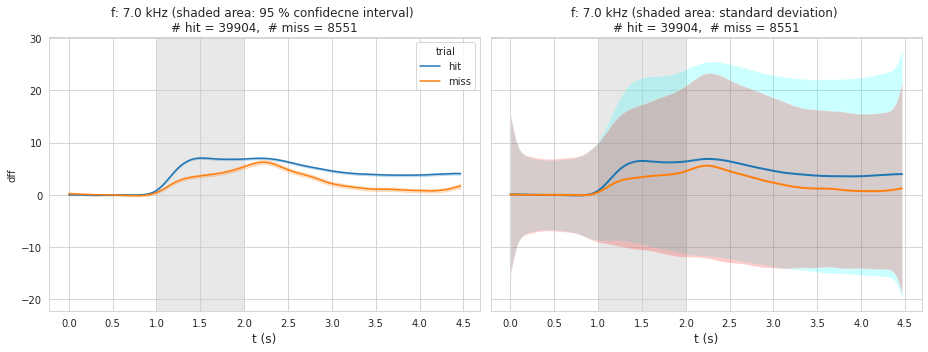

In [3]:
# HIDE CODE

output_trial, output_freq = bag_of_trajectories(dirs_dict['h_load_file'])

sns.set_style('whitegrid')
fig, ax_arr = plt.subplots(1, 2, figsize=(13, 5), sharex='all', sharey='all')

freq = 7000
freq_list = [freq, 7071]
trials_list = ['hit', 'miss']
selected_df = df_all.loc[(df_all.stimfreq.isin(freq_list)) & (df_all.trial.isin(trials_list))]
sns.lineplot(data=selected_df, x='timepoint', y='dff',
             hue='trial', hue_order=trials_list, ax=ax_arr[0])

for trial in trials_list:
    color = 'cyan' if trial == 'hit' else 'red'
    idxs = np.where(output_trial['df'].trial == trial)[0]
    mean = output_trial['dff'][idxs].mean(0)
    std = output_trial['dff'][idxs].std(0)
    ax_arr[1].plot(mean, lw=2)
    ax_arr[1].fill_between(range(len(mean)), mean-std, mean+std, facecolor=color, alpha=0.2)

# get title
trial_counts = Counter(selected_df[selected_df.timepoint == 0].trial)
msg1 = "f: {:.1f} kHz (shaded area: 95 % confidecne interval) \n"
msg2 = "f: {:.1f} kHz (shaded area: standard deviation) \n"
values = [freq / 1000]
for label_idx, item in enumerate(trials_list):
    if label_idx == 0:
        msg1 += "# {:s} = {:d}"
        msg2 += "# {:s} = {:d}"
    else:
        msg1 += ",  # {:s} = {:d}"
        msg2 += ",  # {:s} = {:d}"
    values.extend([item, trial_counts[item]])
    
for i in range(2):
    msg = msg1 if i == 0 else msg2
    ax_arr[i].set_title(msg.format(*values))
    ax_arr[i].axvspan(30, 60, facecolor='lightgrey', alpha=0.5, zorder=0)
    ax_arr[i].set_xticks(xticks)
    ax_arr[i].set_xticklabels([t / 30 for t in xticks])
    ax_arr[i].set_xlabel('t (s)', fontsize=12)

fig.tight_layout()
plt.show()

## Classification on a bag of trajectories

Let us take all the trajectories recorded from neurons.  A given trajectory is either:

1) *EXC*: maximum absolute intensity of the reponses is positive (the cell was excited)<br>
2) *SUP*: maximum absolute intensity of the reponses is negative (the cell was inhibited)

These trajectories come from different trial types.  Here we focus only on **hit** and **miss** trials. We would like to learn a classifier that maps each trajectory to the trial label that it originates from.  We can take the entire trajectory and feed it into classifier, but first we define a simple scalar measure and use that.

### Response magnitude:

Defined as the mean of trajectory values during times $t \in [40, 45)$.  This is the last third of listening period $t \in [30, 45)$, right before licking time onset $t = 45$. We take each trajectory, compute response magnitude, then try to predict trial type label from this scalar.

In [4]:
# HIDE CODE


# process data
trange = range(40, 45)

x = output_trial['dff']
df = output_trial['df']
labels = df.trial.to_numpy()

hit_or_miss = np.where(df.trial.isin(['hit', 'miss']))[0]

x = x[hit_or_miss]
labels = labels[hit_or_miss]

tags = []
max_act = []
for i in range(len(x)):
    _val = max(x[i][trange], key=abs)
    _tag = 'SUP' if _val < 0 else 'EXC'
    max_act.append(_val)
    tags.append(_tag)

mag = x[:, trange].mean(-1, keepdims=True)
y = np.array([output_trial['str2int'][item] for item in labels])


# train/test
tst_indxs = []
trn_indxs = []

for trial in ['hit', 'miss']:
    indxs = np.where(labels == trial)[0]
    tst_indxs.append(indxs[:len(indxs)//5])
    trn_indxs.append(indxs[len(indxs)//5:])

tst_indxs = np.concatenate(tst_indxs)
trn_indxs = np.concatenate(trn_indxs)

assert not set(tst_indxs).intersection(set(trn_indxs))


# clf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score

clf = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',
).fit(mag[trn_indxs], y[trn_indxs])

y_pred = clf.predict(mag[tst_indxs])
balanced_accuracy_score(y[tst_indxs], y_pred)

0.548780148609187

Logistic regression classifier performance: ~55 %, barely above chance

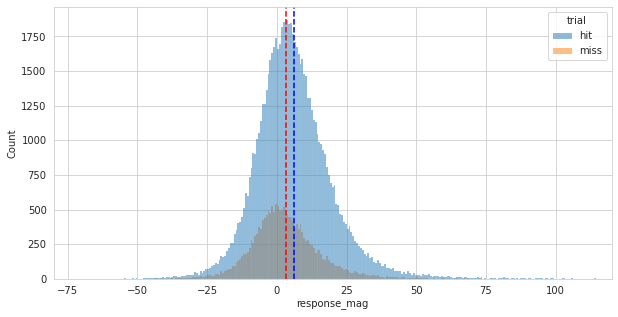

In [5]:
# HIDE CODE

data_dict = {'response_mag': mag.flatten(), 'trial': labels}
tmp_df = pd.DataFrame.from_dict(data_dict)

plt.figure(figsize=(10, 5))
sns.histplot(data=tmp_df, x='response_mag', hue='trial')
plt.axvline(mag[labels == 'hit'].mean(0), color='b', ls='--')
plt.axvline(mag[labels == 'miss'].mean(0), color='r', ls='--')
plt.xlim(-80, 120)
plt.show()

This histogram plot is another evidence that signals are mixed

### What if we only used EXC cells?

In [6]:
# HIDE CODE


# remove SUP cells
sup_indxs = np.where(np.array(tags) == 'SUP')[0]
x_exc = np.delete(x, sup_indxs, axis=0)
labels_exc = np.delete(labels, sup_indxs, axis=0)
mag_exc = np.delete(mag, sup_indxs, axis=0)
y_exc = np.array([output_trial['str2int'][item] for item in labels_exc])


# train/test
tst_indxs = []
trn_indxs = []

for trial in ['hit', 'miss']:
    indxs = np.where(labels_exc == trial)[0]
    tst_indxs.append(indxs[:len(indxs)//5])
    trn_indxs.append(indxs[len(indxs)//5:])

tst_indxs = np.concatenate(tst_indxs)
trn_indxs = np.concatenate(trn_indxs)

assert not set(tst_indxs).intersection(set(trn_indxs))


# clf
clf = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',
).fit(mag[trn_indxs], y[trn_indxs])

y_pred = clf.predict(mag_exc[tst_indxs])
balanced_accuracy_score(y_exc[tst_indxs], y_pred)

0.5246829697902216

Logistic regression classifier performance: ~52 %, again chance level

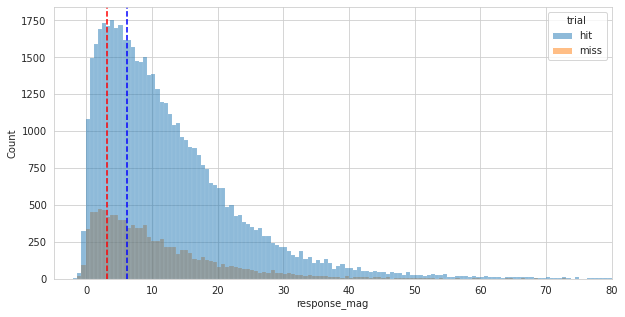

In [7]:
# HIDE CODE

data_dict = {'response_mag': mag_exc.flatten(), 'trial': labels_exc}
tmp_df = pd.DataFrame.from_dict(data_dict)

plt.figure(figsize=(10, 5))
sns.histplot(data=tmp_df, x='response_mag', hue='trial')
plt.axvline(mag[labels == 'hit'].mean(0), color='b', ls='--')
plt.axvline(mag[labels == 'miss'].mean(0), color='r', ls='--')
plt.xlim(-5, 80)
plt.show()

## Discussion
### single cell trajectories are not informative about trial label

We need population level analysis. Ideally, our method will be able to take a variable number of cells and accumulate evidence from each cell and gradually build up toward a prediction about trial label.  This kind of result is interesting because then we can comment about how many cells (and what kind of cells) do we need to make good predictions. Can we say something about the number of cells required for such classification tasks?  Imagine we had access to neural responses from the entirety of A1.  Can we sample a random subpopulation and use only those neurons for prediction and still have high accuracy?  How many neurons do we need?  Which neuron (or response) types are more informative?